In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import copy
import csv

from src.data.dataloader_functions import *
from src.utils.results_utils import *
from src.utils.recovery_analysis_utils import match_declines

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

GREEN = '#2ca02c'
RED = '#d62728'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [31]:
df_all_declines_original = pd.read_csv('data/decline_events_complete.csv')
df_channels = pd.read_csv('data/df_channels_en.tsv', sep='\t', usecols=['channel', 'category_cc'], index_col='channel')
df_data_processed = load_processed_data(usecols=['channel', 'week', 'subs', 'delta_videos', 'activity'])

# Finding the outcome

Using the duration of the decline, determine whether the YouTuber recovered or not.

In [ ]:
df_all_declines = df_all_declines_original.copy()

# If the decline is longer than 3 months without recovery, we consider the YouTuber was not successful in handling it.
# Our aim is to find strategies that lead to quick recoveries, therefore taking more than 3 months would be considered unsuccessful.
RECOVERY_THRESHOLD = 3 * 4

# Add the decline outcome
df_all_declines['Recovered'] = df_all_declines['Duration'] < RECOVERY_THRESHOLD

# Split the tuple (decline start, decline end) into two separate columns
df_all_declines['Event'] = df_all_declines['Event'].apply(lambda s: [int(week_id) for week_id in s[1:-1].split(', ')]) # TODO why is it a string in the first place?
df_all_declines['Start'] = df_all_declines['Event'].apply(lambda e: e[0])
df_all_declines['End'] = df_all_declines['Event'].apply(lambda e: e[1])
df_all_declines.drop('Event', axis=1, inplace=True)

# Add the channel category
df_all_declines['Category'] = df_all_declines['Channel'].apply(lambda c: df_channels.loc[c]['category_cc'])

# Add the channel's subs at the start of the decline
decline_index = list(zip(df_all_declines['Channel'], df_all_declines['Start']))
df_all_declines['Subs_start'] = df_data_processed.loc[decline_index, 'subs'].values

# Add the activity at the start of the decline
df_all_declines['Activity_start'] = df_data_processed.loc[decline_index, 'activity'].values

df_all_declines.head()

,Channel,Duration,Recovered,Start,End,Category,Subs_start,Activity_start
0,UC3igMkdtWOF4p_tOkLsaGBw,6,True,133,139,Science & Technology,112723.000000,1
1,UC3igMkdtWOF4p_tOkLsaGBw,14,False,168,182,Science & Technology,111993.350785,0
2,UC3igMkdtWOF4p_tOkLsaGBw,9,True,227,236,Science & Technology,106037.000000,0
3,UC3igMkdtWOF4p_tOkLsaGBw,6,True,240,246,Science & Technology,104356.000000,0
4,UCOZxsmBiF71H8yDw6JQYO5w,11,True,114,125,People & Blogs,1863.395833,0


# How is the recovery distributed?

To get a first idea of what factors come into play when a YouTuber tries to recover from a decline, we look at the distribution of the recovery outcome based on different features, using a match observational study.

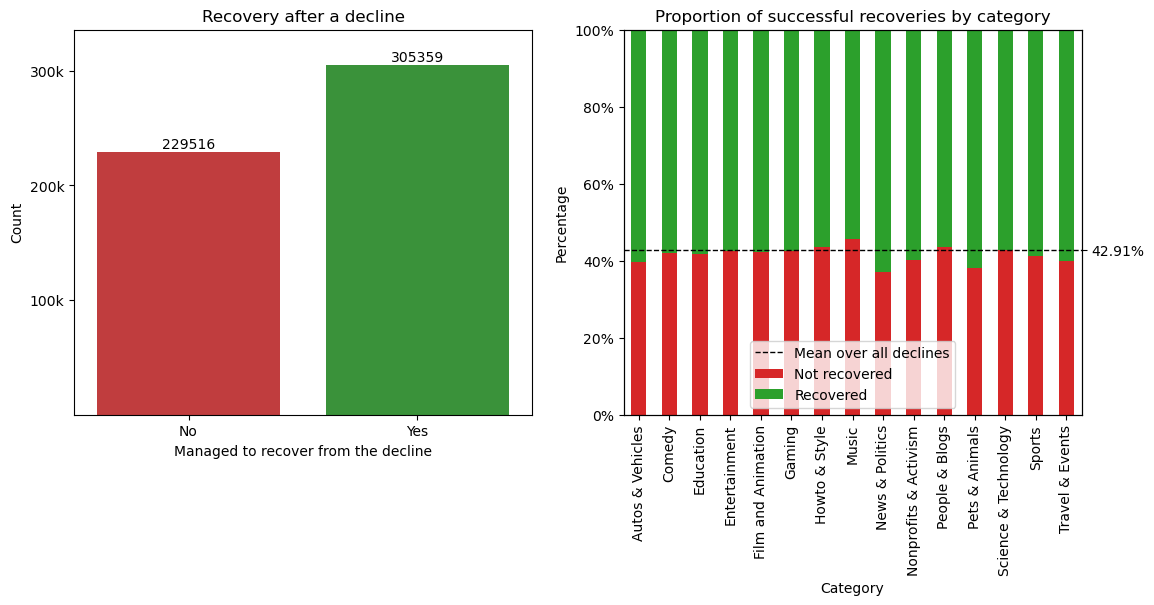

In [ ]:
# TODO use a matched observational study
df_matched = match_declines(df_all_declines, df_data_processed, df_channels)

plt.figure(figsize=(13, 5))
ax = plt.subplot(1, 2, 1)

# show percentage and count of recovered vs not recovered
counts = df_all_declines['Recovered'].value_counts(normalize=False)

sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=[RED, GREEN], legend=False)
plt.title('Recovery after a decline')
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks([100000, 200000, 300000], ['100k', '200k', '300k'])
plt.xlabel('Managed to recover from the decline')
plt.ylabel('Count')
plt.ylim(0, max(counts) * 1.1)

# add text with the percentage
for i, count in enumerate(counts[::-1]):
    plt.text(i, count, count, ha='center', va='bottom')

ax = plt.subplot(1, 2, 2)

# bar plot with categories
counts = df_all_declines.groupby('Category')['Recovered'].value_counts(normalize=True).unstack().fillna(0) * 100
# add mean line
mean =  (1 - df_all_declines['Recovered'].mean()) * 100
plt.axhline(mean, color='black', linestyle='--', linewidth=1)
counts.plot(kind='bar', stacked=True, color=[RED, GREEN], ax=ax, legend=False)
plt.title('Proportion of successful recoveries by category')
plt.xlabel('Category')
plt.ylim(0, 100)
plt.ylabel('Percentage')
plt.yticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'])


# put the mean on the right
ax_right = plt.gca().twinx()
ax_right.set_ylim(0, 100)
ax_right.set_yticks([mean])
ax_right.set_yticklabels([f'{mean:.2f}%'])
ax.legend([f'Mean over all declines', 'Not recovered', 'Recovered'], loc='lower center')

plt.show()

<Figure size 1000x500 with 0 Axes>

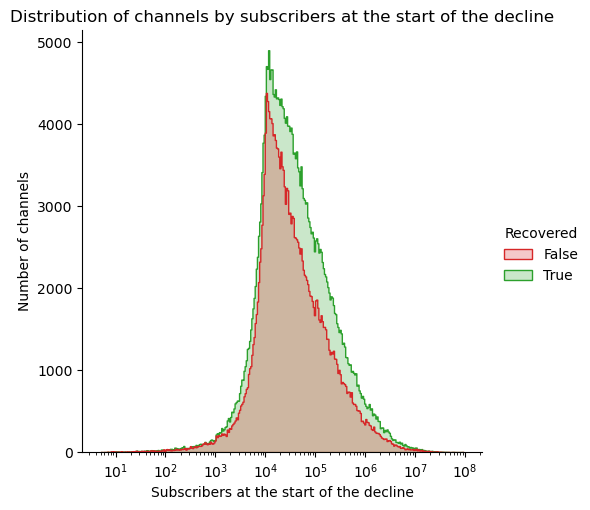

In [40]:
plt.figure(figsize=(10, 5))

sns.displot(data=df_all_declines, x="Subs_start", hue="Recovered", log_scale=True, element="step", kind="hist", palette=[RED, GREEN])

plt.title('Distribution of channels by subscribers at the start of the decline')
plt.xlabel('Subscribers at the start of the decline')
plt.ylabel('Number of channels')

plt.show()

The number of subscribers, as well as the channel's category, do not seem to have an impact on the outcome.

# YouTuber reactions

As we want to find the best ways to deal with a decline depending on the situation, we then take a look at how the YouTubers reacted to the decline, and what methods proved effective.